# Bitmask to polygonal annotation
This notebook contains functions that allow us to transform bitmasks to polygonal annotations in COCO format
## Main code (just for one instance per image, for more than one see bit_to_poly.ipynb)

In [1]:
# from PIL import Image # (pip install Pillow)
import matplotlib.pyplot as plt
import numpy as np                                 # (pip install numpy)
# from skimage import measure                        # (pip install scikit-image)
# from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)
import cv2
import os

%matplotlib inline  

## Converting mask to submasks

### mask_by_color(img,color)
Extracts a list of masks given a list of colors and an image <br/>
img cv2 image <br/>
color list of colors. Example: \[0, 0, 255\]
 

In [2]:
def mask_by_color(img, color):    
    mask = img == color
    return np.all(mask,axis = -1)

In [3]:
def create_submasks(img,colors):
    submasks = []
    black = np.array([0,0,0])
    colors = colors[~(colors==black).all(axis=1),:]
    for color in colors:
        submasks.append(mask_by_color(img,color))
    return submasks

In [4]:
def unique_row_view(data):
    b = np.ascontiguousarray(data).view(
        np.dtype((np.void, data.dtype.itemsize * data.shape[1]))
    )
    u = np.unique(b).view(data.dtype).reshape(-1, data.shape[1])
    return u

In [5]:
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

In [6]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure

def mask_to_annotation(in_mask, img_id, img_cat, ann_id, is_crowd):
    ground_truth_binary_mask = in_mask
    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
    ground_truth_area = mask.area(encoded_ground_truth)
    ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)

    padded_binary_mask = np.pad(ground_truth_binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)

    polygons =[]
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, 0)   #tolerance = 0
        if len(contour) < 3:
            continue

        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)
    
    annotation = {
            "segmentation": polygons,
            "area": ground_truth_area.tolist(),
            "iscrowd": is_crowd,
            "image_id": img_id,
            "bbox": ground_truth_bounding_box.tolist(),
            "category_id": img_cat,
            "id": ann_id
        }
    
    return annotation

In [7]:
def images_to_annotations(dir_path, img_names):
    #Initializing images and annotations lists
    images=[]
    annotations = []
    img_names.sort()
    img_license = 0
    img_id=0
    ann_id=0
    is_crowd=0
           
    for img_name in img_names:
        
        img_path = os.path.join(dir_path, img_name)
        img = cv2.imread(img_path)
        img_size = img.shape
        img_cat = 1
        
        flat_img = np.reshape(img, [-1,3])  # Flattens RGB image
        colors = unique_row_view(flat_img)  # Extracts a list of existing colors
        
        for submask in create_submasks(img,colors):
               
            annotation = mask_to_annotation(submask , img_id, img_cat, ann_id, is_crowd)
            annotations.append(annotation)
            ann_id+=1
            

        new_img={}
        new_img["license"] = img_license
        new_img["file_name"] = img_name.split(".")[0]+".jpg" #Changed to match the video images
        new_img["width"] = img_size[1]
        new_img["height"] = img_size[0]
        new_img["id"] = img_id
        images.append(new_img)

        # sub_masks = create_sub_masks()
        # for color, sub_mask in sub_masks.items():
        #     plt.imshow(sub_mask)
        #     plt.show()
        
        img_id+=1

        sys.stdout.write('\r'+  "Done: {}/{}".format(img_id,len(img_names)))
        sys.stdout.flush()

    return annotations,images

In [8]:
def create_annotation_dict(info, licenses, imgs,categories,anns):
    my_dict = {}
    my_dict["info"]= info
    my_dict["licenses"]= licenses
    my_dict["images"]=imgs
    my_dict["categories"]=categories
    my_dict["annotations"]=anns
    return my_dict

In [9]:
def beep(duration, freq):
    os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

## Creating one dataset

In [10]:
dir_path = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/silhouettes"
# dir_path = '/home/josmar/proyectos/codes/datasets/casia_B1_silhouettes'
img_names=os.listdir(dir_path)
# img_names = filtered_names
color2cat={"[255 255 255]": 1}
info = {
    "description":"ucb_poly_filtered",
    "url":"",
    "version":"0.1",
    "year":2020,
    "contributor":"Josmar Suarez",
    "date_created":"2020/07/14"
}

licenses = [{
        "url": "",
        "id": 0,
        "name": "Attribution-NonCommercial-ShareAlike License"
    }]
categories = [
    {
        "supercategory":"person",
        "id":1,
        "name":"person"
    }
]
anns,imgs = images_to_annotations(dir_path, img_names)
my_dict = create_annotation_dict(info, licenses, imgs,categories,anns)
beep(duration = 1, freq = 440)


Done: 10000/10000

In [11]:
import json 
with open('/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/filtered/filtered_mixed_ucb_gait.json', 'w') as fp:
    json.dump(my_dict, fp)
beep(duration = 1, freq = 440)

## Creating train,val, test datasets

In [11]:
import random
#percent of ____ from 0 to 1
p_train = 0.8
p_val = 0.1
p_test = 0.1

#Reading and shuffling images list
dir_path = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/silhouettes"
all_images = os.listdir(dir_path)
random.shuffle(all_images)
# Length of the image list
n = len(all_images)
# Limits of the index
lim1 = int(p_train*n)
lim2 = lim1 + int(p_val*n)
# Creating lists for each value
train_l = all_images[0:lim1]
val_l = all_images[lim1:lim2]
test_l = all_images[lim2:n]
# Visualizing sizes
print(len(train_l),len(val_l),len(test_l))


16000 2000 2000


In [12]:
# dir_path = '/home/josmar/proyectos/codes/datasets/casia_B1_silhouettes'
all_dicts = [] 
datasets = [train_l,val_l,test_l]
titles = ["Mix Ucb Train","Mix Ucb Val", "Mix Ucb Test"]
index=0
for l in [train_l,val_l,test_l]:
    color2cat={"[255 255 255]": 1}
    info = {
        "description":titles[index],
        "url":"",
        "version":"0.1",
        "year":2020,
        "contributor":"Josmar Suarez",
        "date_created":"2020/10/28"
    }

    licenses = [{
            "url": "",
            "id": 0,
            "name": "Attribution-NonCommercial-ShareAlike License"
        }]
    categories = [
        {
            "supercategory":"person",
            "id":1,
            "name":"person"
        }
    ]
    print("\n",titles[index])
    anns,imgs = images_to_annotations(dir_path, l)
    my_dict = create_annotation_dict(info, licenses, imgs,categories,anns)
    all_dicts.append(my_dict)
    index+=1


 Mix Ucb Train
Done: 16000/16000
 Mix Ucb Val
Done: 2000/2000
 Mix Ucb Test
Done: 2000/2000

In [13]:
import json 
titles = ["/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/ucb_gait_train.json","/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/ucb_gait_val.json", "/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/ucb_gait_test.json"]
index=0
for my_dict in all_dicts:
    with open(titles[index], 'w') as fp:
        json.dump(my_dict, fp)
    index += 1

## Extracting all silhouetes and images in datasets
```
import glob 
import shutil

    
destination_path = "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/silhouettes"
pattern = "/home/josmar/proyectos/codes/annotation_tools/background_substraction/bin_close_images/*/silhouette/*"  
for img in glob.glob(pattern):
    shutil.copy(img, destination_path)
```


## Filtering img_names by mask size from ucb_poly.json

### Functions

In [1]:
def get_ann_info(anns,coco):
    bboxes = []
    masks = []
    labels = []
    for ann in anns:
        bboxes.append(ann["bbox"])
        masks.append(coco.annToMask(ann))
        labels.append(ann["category_id"])
    return labels, bboxes, masks

In [2]:
def ratio_fg_masks(img, masks):
    max_area = img.shape[0] * img.shape[1]
    area = 0
    for mask in masks:
        area += cv2.countNonZero(mask)
    return (area/max_area)

In [3]:
def filter_masks(coco, categories, th_ratio, img_format):
    index=0
    img_names=[]
    
    
    catIds = coco.getCatIds(catNms=categories)
    imgIds = coco.getImgIds(catIds=catIds)
    total=len(imgIds)
    
    
    for img in imgIds:
        coco_img = coco.loadImgs(img)[0]
        img_path = os.path.join(img_dir, coco_img["file_name"])
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        annIds = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds, iscrowd=None)
        coco_anns = coco.loadAnns(annIds)
        
        _, bboxes, masks = get_ann_info(coco_anns,coco)
        ratio = ratio_fg_masks(img,masks)
        if ratio > th_ratio:
            sil_name = "{}.{}".format(coco_img["file_name"].split(".")[0],img_format)
            img_names.append(sil_name)
        index+=1
        
        sys.stdout.write('\r'+  "Done: {}/{}".format(index,total))
        sys.stdout.flush()
    return img_names
    
        # print(ratio)

        # plt.imshow(img)
        # plt.show()
        # # cv2.imwrite("/home/josmar/proyectos/codes/01_annotation_tools/test_data/observed/6.jpg",img)
        # index+=1
        # if index>=10:
        #     break

### Main filtering

In [4]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np

annFile = "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_poly.json"
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=9.17s)
creating index...
index created!


In [17]:
img_dir = "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images"
categories = ["person"]
img_format = "png"
th_ratio = 0.009

filtered_names = filter_masks(coco=coco, categories=categories, th_ratio=th_ratio, img_format=img_format)

Done: 12300/12300

In [19]:
# 0.008 11776/12300
# 0.01  11675  
len(filtered_names) 

11750

## Reviewing dictionary

In [29]:
import json 
with open('/home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/filtered_ucb_gait_poly.json') as f:
    data = json.load(f)

In [30]:
dir_path = "/home/josmar/proyectos/codes/datasets/coco/train2017"
count =0
for image in data["images"]:
    img_path = os.path.join(dir_path, image['file_name'])
    if(os.path.exists(img_path)):
        count+=1
print(count, "/", len(data["images"]))

0 / 11750


In [3]:
lengths=[]
for ann in data["annotations"]:
    l=len(data["annotations"][0]["segmentation"][0])
    lengths.append(l)
print(set(lengths))

{670}


In [4]:
category_list = []
for ann in data["annotations"]:
    category_list.append(ann["category_id"])
print(set(category_list))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90}


In [5]:
n_points = []
tiny = 0
tiny_th = 3
total_anns =len(data["annotations"])
for ann in data["annotations"]:
    ann_points = []
    for i in ann["segmentation"]:
        n=len(i)
        if n < tiny_th:
            tiny+=1
        ann_points.append(n)
    n_points.append(ann_points)
    
    sys.stdout.write('\r'+  "Done: {}/{}".format(ann["image_id"]+1,total_anns))
    sys.stdout.flush()
print("\nTotal_tiny", tiny)


Done: 483737/89608
Total_tiny 0


In [20]:
data["annotations"][2].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

## Verifying anntoMask

In [1]:
from pycocotools.coco import COCO
import cv2
annFile = "/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_train_ucb_gait.json"
coco=COCO(annFile)

loading annotations into memory...
Done (t=9.60s)
creating index...
index created!


In [2]:
annIds = coco.getAnnIds()
all_anns = coco.loadAnns(annIds)
for a in all_anns:
    try:
        coco.annToMask(a)
        sys.stdout.write('\r'+  "Done: {}/{}".format(a["image_id"]+1,len(all_anns)))
        sys.stdout.flush()
    except:
        print("The error is at image_id:",a["image_id"])

Done: 3/19765The error is at image_id: 2
Done: 38/19765The error is at image_id: 38
Done: 189/19765The error is at image_id: 191
Done: 783/19765The error is at image_id: 783
Done: 998/19765The error is at image_id: 997
Done: 1037/19765The error is at image_id: 1037
Done: 1338/19765The error is at image_id: 1337
Done: 1401/19765The error is at image_id: 1401
Done: 1559/19765The error is at image_id: 1558
Done: 1782/19765The error is at image_id: 1781
Done: 1955/19765The error is at image_id: 1954
Done: 2096/19765The error is at image_id: 2095
Done: 2173/19765The error is at image_id: 2172
Done: 2796/19765The error is at image_id: 2796
Done: 2915/19765The error is at image_id: 2915
Done: 2985/19765The error is at image_id: 2984
Done: 3088/19765The error is at image_id: 3088
Done: 3250/19765The error is at image_id: 3249
Done: 3281/19765The error is at image_id: 3280
Done: 4199/19765The error is at image_id: 4198
Done: 4861/19765The error is at image_id: 4861
Done: 6262/19765The error is 

/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_snow2_010-184_007-208.jpg


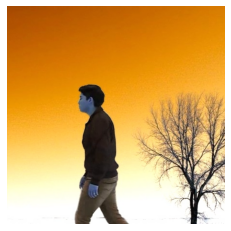

In [13]:
import matplotlib.pyplot as plt
# Getting the image that causes trouble

imgId = 6633
img = coco.loadImgs(imgId)
img_path = "/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/{}".format(img[0]['file_name'])
print(img_path)
I = cv2.imread(img_path)
plt.axis('off')
plt.imshow(I)
plt.show()

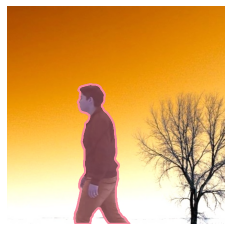

In [14]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [34]:
len(anns)

2

In [12]:
coco.annToMask(anns[1])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
len(anns)

2

In [12]:
anns["img_id"]

TypeError: list indices must be integers or slices, not str